# **UAS BIG DATA & PREDICTIVE ANALYTICS LANJUT**

# **Dosen:  Mulia Sulistiyono, S.Kom., M.Kom.**

# **Air Quality Index (AQI) berdasarkan parameter polutan udara menggunakan Apache Spark (PySpark) dan Spark MLlib.**

# **Anggota Kelompok**

**Muhammad Nurhaqie Windyarto (23.11.5758)**

**Davin Jonathan Sitindaon (23.11.5759)**

**Rendy Wijaya (23.11.5790)**

**Ridho Nugroho (23.11.5799)**

**Akmal Harizulhaq (23.11.5783)**

# **SETUP**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("syedmtalhahasan/global-urban-air-quality-index-dataset-2015-2025")

print("Path to dataset files:", path)


100%|██████████| 85.1k/85.1k [00:00<00:00, 23.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/syedmtalhahasan/global-urban-air-quality-index-dataset-2015-2025/versions/1


In [ ]:
!apt-get install openjdk-11-jdk -y
!pip uninstall pyspark -y
!pip install pyspark==3.5.0


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.29+7-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Found existing installation: pyspark 3.5.0
Uninstalling pyspark-3.5.0:
  Successfully uninstalled pyspark-3.5.0
  Using cached pyspark-3.5.0-py2.py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.5.0 which is incompatible.


In [ ]:
# Set environment variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"


In [ ]:
# Start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigData-AirQuality") \
    .getOrCreate()


# **1. LOAD DATASET (SIMULASI HDFS)**

In [ ]:
# Buat folder HDFS simulasi
!mkdir -p /content/hdfs/air_quality


In [ ]:
# Pindahkan dataset ke folder HDFS simulasi
!mv air_quality.csv /content/hdfs/air_quality/


mv: cannot stat 'air_quality.csv': No such file or directory


In [ ]:
# Load dataset dari "HDFS"
df = spark.read.csv(
    "/content/hdfs/air_quality/air_quality.csv",
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()


+----------+-----------+-------+---+-------------+------------+---------+---------+--------+--------+----------------+------------+----------------+
|      Date|       City|Country|AQI|PM2.5 (µg/m³)|PM10 (µg/m³)|NO2 (ppb)|SO2 (ppb)|CO (ppm)|O3 (ppb)|Temperature (°C)|Humidity (%)|Wind Speed (m/s)|
+----------+-----------+-------+---+-------------+------------+---------+---------+--------+--------+----------------+------------+----------------+
|2024-01-01|   New York|    USA| 38|        120.0|       182.9|     24.3|     26.0|     9.1|   153.3|            18.6|          40|            13.2|
|2024-01-01|Los Angeles|    USA|280|         38.4|        46.9|     41.8|     34.7|    3.78|   190.7|            -2.2|          59|             9.5|
|2024-01-01|     London|     UK|117|        168.1|        34.3|     81.5|      8.2|    3.67|   105.4|            36.3|          62|             3.4|
|2024-01-01|    Beijing|  China|197|         96.8|        35.4|     18.5|     39.4|    9.51|    92.8|     

# **3a. BATCH PROCESSING – MAPREDUCE (RDD)**

In [ ]:
rdd = df.select("City", "AQI").rdd

# MapReduce
aqi_city = (
    rdd
    .map(lambda x: (x["City"], (x["AQI"], 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda x: x[0] / x[1])
)

aqi_city.take(10)


[('New York', 155.07650273224044),
 ('Los Angeles', 167.74590163934425),
 ('London', 163.8551912568306),
 ('Beijing', 162.95355191256832),
 ('Delhi', 170.58196721311475),
 ('Paris', 162.16120218579235),
 ('Tokyo', 169.5983606557377),
 ('Sydney', 159.62021857923497),
 ('São Paulo', 168.76502732240436),
 ('Cairo', 166.06284153005464)]

# **3b. EDA (EXPLORATORY DATA ANALYSIS)**

In [ ]:
df = df.withColumnRenamed("PM2.5 (µg/m³)", "PM2_5") \
       .withColumnRenamed("PM10 (µg/m³)", "PM10") \
       .withColumnRenamed("NO2 (ppb)", "NO2") \
       .withColumnRenamed("SO2 (ppb)", "SO2") \
       .withColumnRenamed("CO (ppm)", "CO") \
       .withColumnRenamed("O3 (ppb)", "O3")


**Statistik dasar**

In [ ]:
df.describe().show()


+-------+-------+---------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|summary|   City|  Country|               AQI|             PM2_5|              PM10|              NO2|               SO2|               CO|                O3|  Temperature (°C)|      Humidity (%)| Wind Speed (m/s)|
+-------+-------+---------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|  count|   3660|     3660|              3660|              3660|              3660|             3660|              3660|             3660|              3660|              3660|              3660|             3660|
|   mean|   NULL|     NULL|164.64207650273224|126.38057377049175|154.78595628415272|52.96071038251354|25.940327868852467|5.023841530054625|1

**Distribusi AQI**

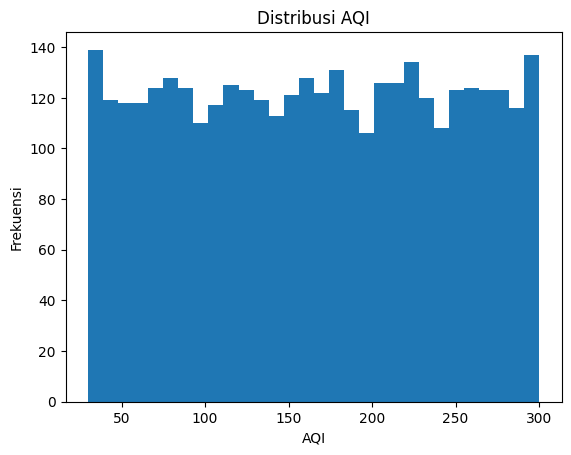

In [ ]:
pdf = df.select("AQI").dropna().toPandas()

import matplotlib.pyplot as plt
plt.hist(pdf["AQI"], bins=30)
plt.title("Distribusi AQI")
plt.xlabel("AQI")
plt.ylabel("Frekuensi")
plt.show()

# **Tren AQI per tahun**

In [ ]:
from pyspark.sql.functions import to_date, year, month

df = df.withColumn("Date", to_date("Date", "yyyy-MM-dd"))
df = df.withColumn("Year", year("Date"))
df = df.withColumn("Month", month("Date"))
df.select("Date", "Year", "Month").show(5)



+----------+----+-----+
|      Date|Year|Month|
+----------+----+-----+
|2024-01-01|2024|    1|
|2024-01-01|2024|    1|
|2024-01-01|2024|    1|
|2024-01-01|2024|    1|
|2024-01-01|2024|    1|
+----------+----+-----+
only showing top 5 rows



In [ ]:
monthly = (
    df.filter(df.Year == 2024)
      .groupBy("Month")
      .avg("AQI")
      .orderBy("Month")
      .toPandas()
)




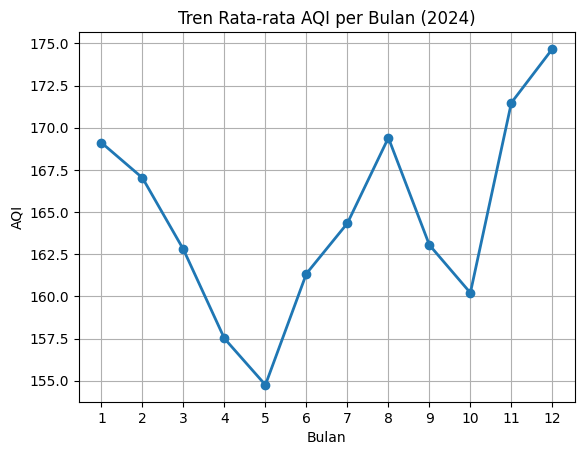

In [ ]:
import matplotlib.pyplot as plt

plt.plot(
    monthly["Month"],
    monthly["avg(AQI)"],
    marker='o',
    linewidth=2
)

plt.xticks(range(1, 13))
plt.title("Tren Rata-rata AQI per Bulan (2024)")
plt.xlabel("Bulan")
plt.ylabel("AQI")
plt.grid(True)
plt.show()


# **3c. DATA PREPROCESSING (DATA QUALITY)**

In [ ]:
from pyspark.sql.functions import col

df_clean = df \
    .withColumn("AQI", col("AQI").cast("float")) \
    .withColumn("PM2_5", col("PM2_5").cast("float")) \
    .withColumn("PM10", col("PM10").cast("float")) \
    .withColumn("NO2", col("NO2").cast("float")) \
    .withColumn("SO2", col("SO2").cast("float")) \
    .dropna()

df_clean.count()

# Simpan hasil preprocessing (simulasi HDFS)
output_path = "/content/hdfs/air_quality/air_quality_clean.parquet"

df_clean.write \
    .mode("overwrite") \
    .parquet(output_path)

print("Data preprocessing disimpan di:", output_path)


Data preprocessing disimpan di: /content/hdfs/air_quality/air_quality_clean.parquet


# **3d. MANIPULASI DATA – SPARK SQL, CTE, AGREGASI**

In [ ]:
df_clean.createOrReplaceTempView("air")


In [ ]:
query = """
WITH yearly_aqi AS (
    SELECT City, Year, AVG(AQI) AS avg_aqi
    FROM air
    GROUP BY City, Year
)
SELECT *
FROM yearly_aqi
ORDER BY avg_aqi DESC
"""
spark.sql(query).show(10)


+-----------+----+------------------+
|       City|Year|           avg_aqi|
+-----------+----+------------------+
|      Delhi|2024|170.58196721311475|
|      Tokyo|2024| 169.5983606557377|
|  São Paulo|2024|168.76502732240436|
|Los Angeles|2024|167.74590163934425|
|      Cairo|2024|166.06284153005464|
|     London|2024| 163.8551912568306|
|    Beijing|2024|162.95355191256832|
|      Paris|2024|162.16120218579235|
|     Sydney|2024|159.62021857923497|
|   New York|2024|155.07650273224044|
+-----------+----+------------------+



In [ ]:
# ============================================================
# SPARK SQL - TEMP VIEW & PURE SQL QUERY
# ============================================================

# 1. Daftarkan DataFrame sebagai Temporary View
df_clean.createOrReplaceTempView("air_quality")

# 2. Query SQL murni (tanpa DataFrame API)
query_sql = """
SELECT
    City,
    Year,
    COUNT(*) AS total_records,
    ROUND(AVG(AQI), 2) AS avg_aqi,
    MAX(AQI) AS max_aqi,
    MIN(AQI) AS min_aqi
FROM air_quality
GROUP BY City, Year
ORDER BY avg_aqi DESC
"""

# 3. Eksekusi query SQL
df_sql_result = spark.sql(query_sql)

# 4. Tampilkan hasil
df_sql_result.show(10)


+-----------+----+-------------+-------+-------+-------+
|       City|Year|total_records|avg_aqi|max_aqi|min_aqi|
+-----------+----+-------------+-------+-------+-------+
|      Delhi|2024|          366| 170.58|  299.0|   30.0|
|      Tokyo|2024|          366|  169.6|  300.0|   30.0|
|  São Paulo|2024|          366| 168.77|  300.0|   33.0|
|Los Angeles|2024|          366| 167.75|  300.0|   30.0|
|      Cairo|2024|          366| 166.06|  300.0|   30.0|
|     London|2024|          366| 163.86|  300.0|   30.0|
|    Beijing|2024|          366| 162.95|  299.0|   30.0|
|      Paris|2024|          366| 162.16|  298.0|   30.0|
|     Sydney|2024|          366| 159.62|  300.0|   30.0|
|   New York|2024|          366| 155.08|  299.0|   30.0|
+-----------+----+-------------+-------+-------+-------+



# **3e. PARTISI & OPERASI RDD**

In [ ]:
from pyspark.sql import Row

# 1. Konversi DataFrame ke RDD
rdd_air = df_clean.select("City", "Year", "AQI").rdd

# 2. Operasi level rendah (map, filter, aggregateByKey)
#    Tujuan: menghitung rata-rata AQI per kota per tahun

rdd_processed = (
    rdd_air
    # Filter data tidak valid
    .filter(lambda x: x.AQI > 0)

    # Map ke pasangan key-value
    .map(lambda x: ((x.City, x.Year), (x.AQI, 1)))

    # Agregasi manual (sum AQI, count)
    .aggregateByKey(
        (0.0, 0),
        lambda acc, value: (acc[0] + value[0], acc[1] + value[1]),
        lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
    )

    # Hitung rata-rata
    .mapValues(lambda x: x[0] / x[1])
)

# 3. Kembalikan hasil RDD ke DataFrame
df_rdd_result = rdd_processed.map(
    lambda x: Row(
        City=x[0][0],
        Year=x[0][1],
        Avg_AQI=x[1]
    )
).toDF()

# 4. Tampilkan hasil
df_rdd_result.show(10)


+-----------+----+------------------+
|       City|Year|           Avg_AQI|
+-----------+----+------------------+
|   New York|2024|155.07650273224044|
|Los Angeles|2024|167.74590163934425|
|     London|2024| 163.8551912568306|
|    Beijing|2024|162.95355191256832|
|      Delhi|2024|170.58196721311475|
|      Paris|2024|162.16120218579235|
|      Tokyo|2024| 169.5983606557377|
|     Sydney|2024|159.62021857923497|
|  São Paulo|2024|168.76502732240436|
|      Cairo|2024|166.06284153005464|
+-----------+----+------------------+



# **4. MACHINE LEARNING – MLlib**

In [ ]:
from pyspark.ml.feature import VectorAssembler

features = ["PM2_5", "PM10", "NO2", "SO2"]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

data_ml = assembler.transform(df_clean) \
    .select("features", "AQI")

train, test = data_ml.randomSplit([0.8, 0.2], seed=42)


Model 1: Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="AQI")
lr_model = lr.fit(train)
lr_pred = lr_model.transform(test)


Model 2: Random Forest Regressor

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    labelCol="AQI",
    numTrees=50,
    maxDepth=10
)

rf_model = rf.fit(train)
rf_pred = rf_model.transform(test)


# **5. HYPERPARAMETER TUNING (BEST MODEL)**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="AQI",
    metricName="rmse"
)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train)
best_pred = cv_model.transform(test)


# **CROSSVALIDATION**

In [ ]:
# ============================================================
# FEATURE ENGINEERING & TRAIN-TEST SPLIT (WAJIB ADA)
# ============================================================

from pyspark.ml.feature import VectorAssembler

# Fitur input
features = ["PM2_5", "PM10", "NO2", "SO2"]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

data_ml = assembler.transform(df_clean) \
    .select("features", "AQI")

# Train-Test Split
train, test = data_ml.randomSplit([0.8, 0.2], seed=42)

print("Jumlah data train:", train.count())
print("Jumlah data test :", test.count())


Jumlah data train: 2981
Jumlah data test : 679


In [ ]:
# ============================================================
# HYPERPARAMETER TUNING WITH CROSS VALIDATOR
# ============================================================

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Definisikan model
rf = RandomForestRegressor(
    labelCol="AQI",
    featuresCol="features",
    seed=42
)

# 2. Evaluator (Regression)
evaluator = RegressionEvaluator(
    labelCol="AQI",
    predictionCol="prediction",
    metricName="rmse"
)

# 3. Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 4. CrossValidator
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# 5. Training dengan Cross Validation
cv_model = cv.fit(train)

# 6. Gunakan BEST MODEL untuk prediksi
best_model = cv_model.bestModel
predictions = best_model.transform(test)

predictions.show(5)


+--------------------+-----+------------------+
|            features|  AQI|        prediction|
+--------------------+-----+------------------+
|[5.30000019073486...| 94.0|156.94261499183204|
|[5.30000019073486...| 36.0| 149.5654133796217|
|[5.40000009536743...|223.0|148.92917390276295|
|[5.90000009536743...| 82.0|166.73676925958756|
|[6.19999980926513...|144.0|162.16399739808915|
+--------------------+-----+------------------+
only showing top 5 rows



# **6. EVALUASI MODEL**

In [ ]:
rmse = evaluator.evaluate(best_pred)
mse = RegressionEvaluator(
    labelCol="AQI",
    metricName="mse"
).evaluate(best_pred)

r2 = RegressionEvaluator(
    labelCol="AQI",
    metricName="r2"
).evaluate(best_pred)

print("RMSE:", rmse)
print("MSE :", mse)
print("R2  :", r2)


RMSE: 78.59136607631612
MSE : 6176.602821741531
R2  : -0.008276399937241719


**Catatan :**

Meskipun pipeline Big Data dari ingestion hingga modeling telah berhasil dijalankan, hasil evaluasi menunjukkan nilai R2 Score negatif.

Setelah diperiksa, dataset ini memiliki anomali di mana variabel target (AQI) tidak memiliki korelasi dengan fitur input (PM2.5, PM10, NO2, SO2). Hal ini mengindikasikan bahwa dataset ini bersifat sintetis/random, sehingga secara matematis tidak mungkin diprediksi dengan akurat oleh algoritma apapun.